### Loading the modules and data

In [1]:
import numpy as np

from __future__ import print_function

import keras
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, Conv1D, MaxPooling2D, MaxPooling1D
from keras.layers import RNN, LSTM, Bidirectional, Reshape
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
import matplotlib.pylab as plt

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.chdir("/content/drive/My Drive/Sundar_Notebooks")
!ls

 Archive.zip			   person_test.npy
 BasicCNN.ipynb			   person_train_valid.npy
 BasicCNN-varshinee.ipynb	   Prob_aggregation.ipynb
 BiRNN_Sundar.ipynb		   RNN_Mathanky-66.ipynb
'CNN results log.docx'		   RNN_Sundar.ipynb
 CNN_results_log_Sundar.docx	   X_test.npy
'Copy of Prob_aggregation.ipynb'   X_train_valid.npy
 FCLayers.ipynb			   y_test.npy
 model				   y_train_valid.npy


#### Data loading and preperation

The following two cells load the data and prepare it to be suitable for input to neural network models. Run them only once.

In [0]:
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train = np.load("person_train_valid.npy")
X_train = np.load("X_train_valid.npy")
y_train = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

In [0]:
### Swapping axes for inputs.
###  Reason is that we need the number of channels as 25

X_train = np.swapaxes(X_train,1,2)
X_test = np.swapaxes(X_test,1,2)

#### y labels are in the range 769 to 772, wrapping them back to 0 - 3
y_train -= 769
y_test -= 769

num_classes = 4
#### massaging y labels to suit to input to our ML model

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


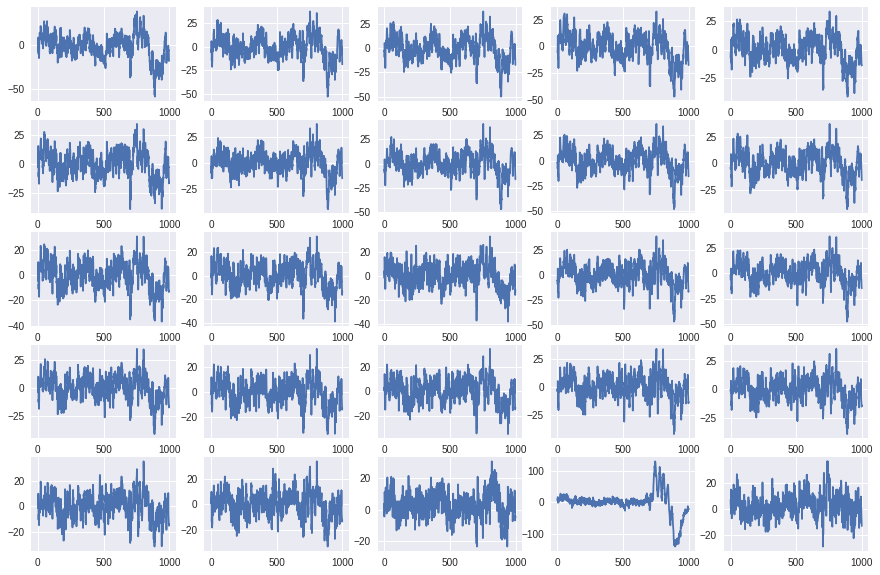

In [0]:
f, ax = plt.subplots(5,5,figsize=(15,10))

for i in np.arange(25):
    idx = i%5
    idy = i//5
    ax[idy,idx].plot(X_train[45,:,i])
plt.show()

### Feature extraction 
I am using a simple wavelet decomposition here, but more complicated techniques could be used.

In [0]:
import pywt

num_signals = 22 ### 25 if using EOG, 22 otherwise
feat_extract = False

if feat_extract:
    mother = 'db4'
    levels = 3
    mode = 'zero'
    feats_train = pywt.wavedec(X_train,mother,axis = 1, level = levels, mode = mode)
    feats_train = np.concatenate(feats_train,axis = 1)
    feats_test = pywt.wavedec(X_test,mother,axis = 1, level = levels, mode = mode)
    feats_test = np.concatenate(feats_test,axis = 1)
else:
    feats_train = X_train
    feats_test = X_test

feats_train = feats_train[:,:,0:num_signals]
feats_test = feats_test[:,:,0:num_signals]

#### Feature scaling

In [0]:
feat_scale = 'on' ####making features 0 mean and unit variance

if feat_scale == 'on':
    temp = feats_train - feats_train.mean(axis=(0))
    temp = temp/feats_train.std(axis=(0))
    feats_train = temp
    temp = feats_test - feats_test.mean(axis=(0))
    temp = temp/feats_test.std(axis=(0))
    feats_test = temp


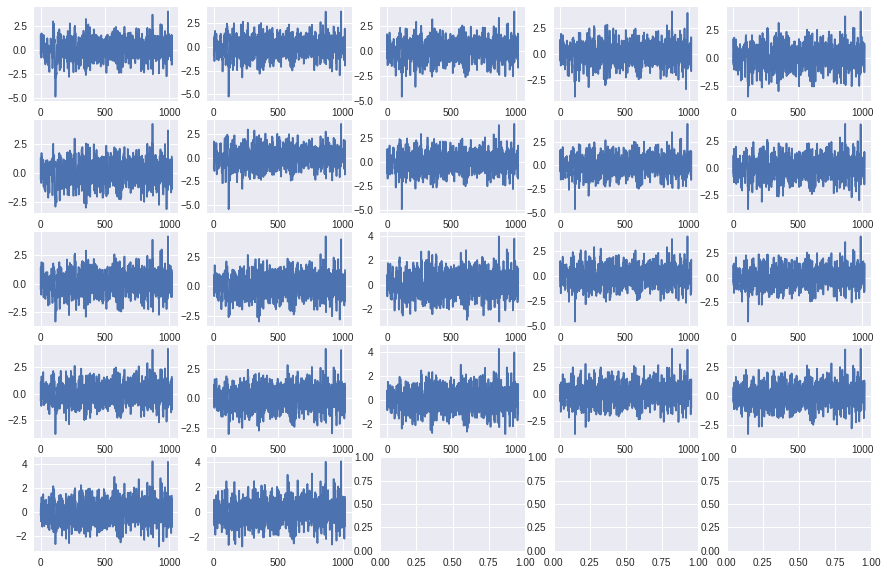

In [0]:
f, ax = plt.subplots(5,5,figsize=(15,10))

for i in np.arange(22):
    idx = i%5
    idy = i//5
    ax[idy,idx].plot(feats_train[45,:,i])
plt.show()

### Shape of data

In [0]:
print ('Training/Valid data shape: {}'.format(feats_train.shape))
print ('Test data shape: {}'.format(feats_test.shape))
print ('Training/Valid target shape: {}'.format(y_train.shape))
print ('Test target shape: {}'.format(y_test.shape))
print ('Person train/valid shape: {}'.format(person_train.shape))
print ('Person test shape: {}'.format(person_test.shape))


Training/Valid data shape: (2115, 1020, 22)
Test data shape: (443, 1020, 22)
Training/Valid target shape: (2115, 4)
Test target shape: (443, 4)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


#### Setting some constants for classification

In [0]:
num_classes = 4
N, W, C = feats_train.shape

#### Setting some hyperparameters for the architecture

In [0]:
L = 3 ### Number of layers (one layer is conv->activation->pooling->drpout->batchnorm)
p = 0.3 ## dropout probability
num_filters = 128 #### for convolutional layers
filter_shape = 3
pool_size = 3 ## size of pooling filters
dense_layer_size = 64

#### Definining the sequential model

The following cell defines the sequential model we will run. We will play around with different architectures and layers and log the error rates for each of these.

In [16]:
model = Sequential()

model.add(Reshape((-1, 1), input_shape=(W,C)))
model.add(Flatten())

model.add(Dense(dense_layer_size, activation='relu'))
model.add(Dropout(p))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(Dropout(p))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(Dropout(p))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

# chk_path = os.path.join(model_dir, 'best_{}_{}'.format(NAME,t))
# checkpoint = ModelCheckpoint(chk_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
# tensorboard = TensorBoard(log_dir="logs/{}_{}".format(NAME,t))
# callbacks_list = [checkpoint, tensorboard]

class AccuracyHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []

    def on_epoch_end(self, batch, logs={}):
        self.acc.append(logs.get('acc'))

history = AccuracyHistory()
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 22000, 1)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 22000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                1408064   
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 512)               33280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
__________

#### Training and performance evaluation for the model above

Train on 1903 samples, validate on 212 samples
Epoch 1/50
1903/1903 [==============================] - 2s 1ms/step - loss: 1.9267 - acc: 0.2874 - val_loss: 1.6320 - val_acc: 0.2972
Epoch 2/50
1903/1903 [==============================] - 1s 435us/step - loss: 1.6158 - acc: 0.3542 - val_loss: 1.6260 - val_acc: 0.3302
Epoch 3/50
1903/1903 [==============================] - 1s 440us/step - loss: 1.5008 - acc: 0.4041 - val_loss: 1.6458 - val_acc: 0.3443
Epoch 4/50
1903/1903 [==============================] - 1s 436us/step - loss: 1.3458 - acc: 0.4493 - val_loss: 1.7153 - val_acc: 0.3538
Epoch 5/50
1903/1903 [==============================] - 1s 439us/step - loss: 1.1736 - acc: 0.5134 - val_loss: 1.7633 - val_acc: 0.3585
Epoch 6/50
1903/1903 [==============================] - 1s 449us/step - loss: 1.1233 - acc: 0.5166 - val_loss: 1.6409 - val_acc: 0.3632
Epoch 7/50
1903/1903 [==============================] - 1s 442us/step - loss: 1.0432 - acc: 0.5717 - val_loss: 1.7002 - val_acc: 0.3632
Epo

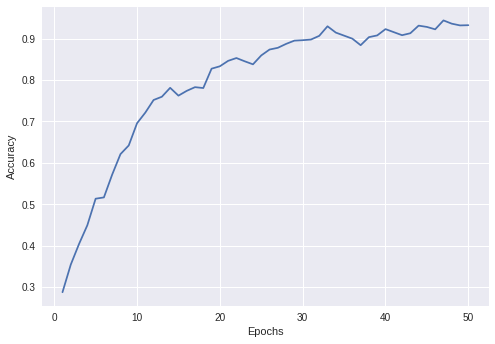

In [17]:
#### Hyperparameters for SGD####
epochs = 50
batch_size = 50

import time
start = time.time()
##### Training ######
model.fit(feats_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.1,
          callbacks=[history], shuffle = True)


##### Testing #####
score = model.evaluate(feats_test, y_test, verbose=0)

end = time.time()

print('Time taken to train: {} minutes'.format((end-start)//60))

print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(range(1, epochs+1), history.acc)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

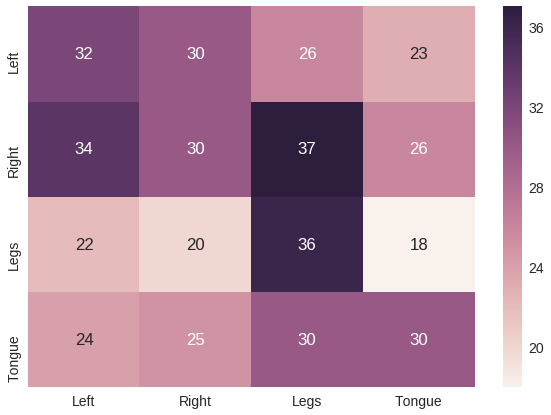

In [0]:

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
y_pred =  model.predict(feats_test, verbose=0).argmax(axis=-1)

y_test_cm = np.load("y_test.npy") -769
labels = [0,1,2,3]
cm = confusion_matrix(y_test_cm,y_pred, labels)
df_cm = pd.DataFrame(cm, index = [i for i in ['Left','Right','Legs','Tongue']],
                  columns = [i for i in ['Left','Right','Legs','Tongue']])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

In [0]:
y_pred =  model.predict(feats_test, verbose=0).argmax(axis=-1)
y_pred.dtype

dtype('int64')

In [0]:
y_test_cm.dtype

dtype('int32')